In [1]:
from data_reader import DataReader
import datasets
from tweet_to_vec import TweetToVec
import utils
from LSTM import LSTMModel
from evaluate import evaluate1
from evaluate import evaluate2
import os
import matplotlib.pyplot as plt

import torch
from tqdm import tqdm
import numpy as np
from torch import nn, optim
import torch.nn as nn

In [2]:
dr = DataReader('nlkt')
dr.read_dataset(datasets.binary_classes, False)
dr.read_dataset(datasets.ternary_classes, False)
embeddings = dr.read_embeddings('embeddings/kraby.txt', False)

binary_dataset = dr.get_dataset('binary')
binary_dataset = utils.extract_validation_from_training(binary_dataset)

ternary_dataset = dr.get_dataset('ternary')
ternary_dataset = utils.extract_validation_from_training(ternary_dataset)

In [3]:
def test(dataset, epochs, method, L, size, num_layers, dropout, prediction_method, equalize_training_classes, learning_rate, number_of_output_classes):
    batch_size = 32
    t2v = TweetToVec(embeddings, method, L)

    if equalize_training_classes:
        dataset = utils.equalize_training_classes(dataset)
    vectorized_dataset = t2v.vectorize_dataset(dataset)
    def gen_batched():
        batched_dataset = t2v.batch_dataset(vectorized_dataset, batch_size, True, True)
        return batched_dataset['training tweets'], batched_dataset['training tags']

    model = LSTMModel(size=size, embedding_dim=100,num_layers=num_layers, dropout=dropout, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=learning_rate)

    batched = t2v.batch_dataset(vectorized_dataset, batch_size, True, False)
    tweets = batched['validation tweets']
    tags = batched['validation tags']
    current_best_score = 0
    best_model_path = ""
    params_string = f'_number_of_output_classes_{number_of_output_classes}_method_{method}_L_{L}_size_{size}_num_layers_{num_layers}_dropout_{dropout}_prediction_method_{prediction_method}_equalize_training_classes_{equalize_training_classes}_learnig_rate_{learning_rate}'
    
    scores = []

    for i in range(epochs):
        model.train_model(gen_batched, 1)
        model.eval()
        predictions = model.predict(tweets)
        score = 0
        if number_of_output_classes == 2:
            score = evaluate1(predictions, tags)['balancedf']
            print(" balancedf score on valid =", score)
        else:
            score = evaluate2(predictions, tags)['microAverageFscore']
            print(" microAverageFscore score on valid =", score)  
        scores.append(score)  
        if score > current_best_score:
            if len(best_model_path) > 0:
                os.remove(best_model_path)
            current_best_score = score
            str_score = str(score * 100)
            str_score = str_score[:min(len(str_score), 5)]
            best_model_path = 'models/LSTM_' + str_score + params_string + '.model'
            torch.save(model.state_dict(), best_model_path)
    

    plt.plot(scores)
    plt.ylabel('scores on validation over epochs')
    plt.show()
    print("Best score = ", current_best_score)

In [4]:
def evaluate_on_test(filename, dataset, size, num_layers, dropout, L, prediction_method, method, number_of_output_classes):
    model = LSTMModel(size=size, embedding_dim=100,num_layers=num_layers, dropout=dropout, number_of_output_classes=number_of_output_classes, L=L, prediction_method=prediction_method, learning_rate=0.0001)
    model.load_state_dict(torch.load(filename))
    model.eval()

    t2v = TweetToVec(embeddings, method, L)
    
    vectorized_dataset = t2v.vectorize_dataset(dataset)

    batched = t2v.batch_dataset(vectorized_dataset, 1, True, False)
    tweets = batched['test tweets']
    tags = batched['test tags']

    predictions = model.predict(tweets)
    if number_of_output_classes == 2:
        score = evaluate1(predictions, tags)['balancedf']
        print(" balancedf score on test =", score)
    else:
        score = evaluate2(predictions, tags)['microAverageFscore']
        print(" microAverageFscore score on test =", score)

## Hyperparameters turning of LSTM on binary problem

### First round of hyperparameters turning

In [15]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=3, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001,
     number_of_output_classes=2)

After epoch 0 tot_loss = 330.7593688964844 balancedf score on valid = 0.4438040345821325
After epoch 1 tot_loss = 229.4430389404297 balancedf score on valid = 0.42890442890442887
After epoch 2 tot_loss = 205.07293701171875 balancedf score on valid = 0.5142857142857142
After epoch 3 tot_loss = 189.1519775390625 balancedf score on valid = 0.5448028673835126
After epoch 4 tot_loss = 172.0915069580078 balancedf score on valid = 0.4955223880597015
After epoch 5 tot_loss = 160.54396057128906 balancedf score on valid = 0.548611111111111
After epoch 6 tot_loss = 145.79762268066406 balancedf score on valid = 0.5482625482625484
After epoch 7 tot_loss = 135.139404296875 balancedf score on valid = 0.5343511450381679
After epoch 8 tot_loss = 124.82476806640625 balancedf score on valid = 0.5413533834586467
After epoch 9 tot_loss = 117.57150268554688 balancedf score on valid = 0.5056603773584906
After epoch 10 tot_loss = 113.15058898925781 balancedf score on valid = 0.5104895104895105
After epoch 11 

KeyboardInterrupt: 

In [18]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d',
     L=30, 
     size=128, 
     num_layers=3, 
     dropout=0.5, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 359.6738586425781 balancedf score on valid = 0.24096385542168675
After epoch 1 tot_loss = 351.4238586425781 balancedf score on valid = 0.402332361516035
After epoch 2 tot_loss = 265.6184997558594 balancedf score on valid = 0.45989304812834225
After epoch 3 tot_loss = 244.39102172851562 balancedf score on valid = 0.4648648648648649
After epoch 4 tot_loss = 234.86766052246094 balancedf score on valid = 0.4756756756756756
After epoch 5 tot_loss = 225.9877166748047 balancedf score on valid = 0.48648648648648646
After epoch 6 tot_loss = 220.8006134033203 balancedf score on valid = 0.45500000000000007
After epoch 7 tot_loss = 213.50601196289062 balancedf score on valid = 0.48517520215633425
After epoch 8 tot_loss = 209.81399536132812 balancedf score on valid = 0.48913043478260876
After epoch 9 tot_loss = 204.04710388183594 balancedf score on valid = 0.48947368421052634
After epoch 10 tot_loss = 200.35482788085938 balancedf score on valid = 0.4881889763779527
After ep

NameError: name 'plt' is not defined

After epoch 0 tot_loss = 234.8706512451172 balancedf score on valid = 0.509090909090909
After epoch 1 tot_loss = 154.11866760253906 balancedf score on valid = 0.5285714285714286
After epoch 2 tot_loss = 114.95923614501953 balancedf score on valid = 0.5454545454545455
After epoch 3 tot_loss = 92.57653045654297 balancedf score on valid = 0.5384615384615384
After epoch 4 tot_loss = 74.16268920898438 balancedf score on valid = 0.5064377682403434
After epoch 5 tot_loss = 62.922080993652344 balancedf score on valid = 0.5110132158590307
After epoch 6 tot_loss = 54.043251037597656 balancedf score on valid = 0.5462962962962963
After epoch 7 tot_loss = 48.48476028442383 balancedf score on valid = 0.5263157894736842
After epoch 8 tot_loss = 43.323909759521484 balancedf score on valid = 0.5391304347826086
After epoch 9 tot_loss = 39.457298278808594 balancedf score on valid = 0.5581395348837208
After epoch 10 tot_loss = 34.16588592529297 balancedf score on valid = 0.5309734513274337
After epoch 11 

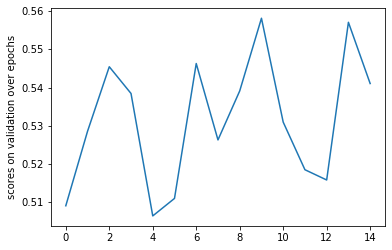

Best score =  0.5581395348837208


In [22]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256, 
     num_layers=2, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 359.8977966308594 balancedf score on valid = 0.37377049180327865
After epoch 1 tot_loss = 268.52410888671875 balancedf score on valid = 0.4248704663212435
After epoch 2 tot_loss = 235.3164825439453 balancedf score on valid = 0.4740259740259741
After epoch 3 tot_loss = 221.3602294921875 balancedf score on valid = 0.47023809523809523
After epoch 4 tot_loss = 211.97708129882812 balancedf score on valid = 0.47734138972809664
After epoch 5 tot_loss = 203.66969299316406 balancedf score on valid = 0.49132947976878616
After epoch 6 tot_loss = 195.34800720214844 balancedf score on valid = 0.5107913669064749
After epoch 7 tot_loss = 188.8491973876953 balancedf score on valid = 0.527331189710611
After epoch 8 tot_loss = 183.0036163330078 balancedf score on valid = 0.5206349206349207
After epoch 9 tot_loss = 177.36314392089844 balancedf score on valid = 0.5192307692307693
After epoch 10 tot_loss = 173.70230102539062 balancedf score on valid = 0.5197368421052632
After epoch

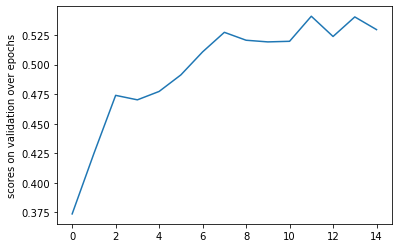

Best score =  0.5409252669039146


In [23]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

Last model was learning steadily and achieved a very nice score. The rest seemed to be randomly increasing and decreasing the result. We know that the loss is not compatible with the score we want to minimize, thus minimal loss doesn't mean everything to us.

### Second iterations round (small changed of the best from the previous round)

After epoch 0 tot_loss = 302.0845031738281 balancedf score on valid = 0.4299065420560748
After epoch 1 tot_loss = 233.60458374023438 balancedf score on valid = 0.4930747922437673
After epoch 2 tot_loss = 213.33242797851562 balancedf score on valid = 0.4981949458483754
After epoch 3 tot_loss = 201.34019470214844 balancedf score on valid = 0.5028901734104047
After epoch 4 tot_loss = 190.97964477539062 balancedf score on valid = 0.527331189710611
After epoch 5 tot_loss = 185.15469360351562 balancedf score on valid = 0.5519713261648745
After epoch 6 tot_loss = 175.1431884765625 balancedf score on valid = 0.5517241379310345
After epoch 7 tot_loss = 168.17605590820312 balancedf score on valid = 0.5276872964169381
After epoch 8 tot_loss = 163.77670288085938 balancedf score on valid = 0.5415162454873647
After epoch 9 tot_loss = 157.2568817138672 balancedf score on valid = 0.5369127516778524
After epoch 10 tot_loss = 151.3604736328125 balancedf score on valid = 0.5357142857142858
After epoch 11

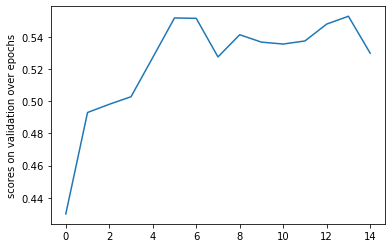

Best score =  0.5530303030303031


In [26]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=256,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 242.71006774902344 balancedf score on valid = 0.5311475409836065
After epoch 1 tot_loss = 170.85586547851562 balancedf score on valid = 0.5088757396449703
After epoch 2 tot_loss = 135.07183837890625 balancedf score on valid = 0.5182724252491694
After epoch 3 tot_loss = 111.8652572631836 balancedf score on valid = 0.5650224215246636
After epoch 4 tot_loss = 96.95565032958984 balancedf score on valid = 0.5168539325842697
After epoch 5 tot_loss = 80.54532623291016 balancedf score on valid = 0.5079365079365079
After epoch 6 tot_loss = 71.7242431640625 balancedf score on valid = 0.5
After epoch 7 tot_loss = 64.42375183105469 balancedf score on valid = 0.5288461538461539
After epoch 8 tot_loss = 58.333404541015625 balancedf score on valid = 0.541871921182266
After epoch 9 tot_loss = 51.72410202026367 balancedf score on valid = 0.5284552845528455
After epoch 10 tot_loss = 49.97296142578125 balancedf score on valid = 0.5570776255707763
After epoch 11 tot_loss = 42.7774

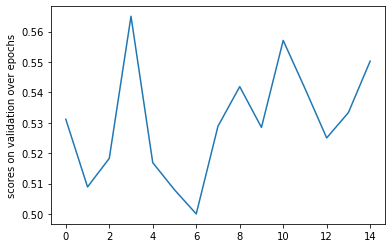

Best score =  0.5650224215246636


In [27]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.001, 
     number_of_output_classes=2)

In [6]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=3, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

After epoch 0 tot_loss = 365.2879943847656 balancedf score on valid = 0.020408163265306128
After epoch 1 tot_loss = 313.4440612792969 balancedf score on valid = 0.40129449838187703
After epoch 2 tot_loss = 238.50389099121094 balancedf score on valid = 0.41403508771929826
After epoch 3 tot_loss = 223.94395446777344 balancedf score on valid = 0.3604060913705584
After epoch 4 tot_loss = 214.2071533203125 balancedf score on valid = 0.41471571906354515


In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.8, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='last',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.01, 
     number_of_output_classes=2)

In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=False, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

In [ ]:
test(dataset=binary_dataset, 
     epochs=15,
     method='fixed_length_2d', 
     L=20, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=False, 
     learning_rate=0.0001, 
     number_of_output_classes=2)

### Evaluation of the best LSTM model on binary problem

In [16]:
evaluate_on_test('models/LSTM_55.23_number_of_output_classes_2_method_fixed_length_2d_L_30_size_256_num_layers_3_dropout_0.2_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.0001.model',
                 dataset=binary_dataset,
                 size=256,
                 num_layers=3,
                 dropout=0.2,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.5735849056603773


In [21]:
evaluate_on_test('models/LSTM_49.70_number_of_output_classes_2_method_fixed_length_2d_L_30_size_128_num_layers_3_dropout_0.5_prediction_method_max_equalize_training_classes_True_learnig_rate_0.0001.model',                 
                 dataset=binary_dataset,
                 size=128,
                 num_layers=3,
                 dropout=0.5,
                 L=30,
                 prediction_method='max',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.5653333333333332


In [24]:
evaluate_on_test('models/LSTM_55.81_number_of_output_classes_2_method_fixed_length_2d_L_30_size_256_num_layers_2_dropout_0.2_prediction_method_max_equalize_training_classes_True_learnig_rate_0.001.model',                 
                 dataset=binary_dataset,
                 size=256,
                 num_layers=2,
                 dropout=0.2,
                 L=30,
                 prediction_method='max',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.502127659574468


In [25]:
evaluate_on_test('models/LSTM_54.09_number_of_output_classes_2_method_fixed_length_2d_L_30_size_128_num_layers_2_dropout_0.5_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.0001.model',                 
                 dataset=binary_dataset,
                 size=128,
                 num_layers=2,
                 dropout=0.5,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.5874587458745875


In [5]:
evaluate_on_test('models/LSTM_56.50_number_of_output_classes_2_method_fixed_length_2d_L_30_size_128_num_layers_2_dropout_0.5_prediction_method_sum_equalize_training_classes_True_learnig_rate_0.001.model',                 
                 dataset=binary_dataset,
                 size=128,
                 num_layers=2,
                 dropout=0.5,
                 L=30,
                 prediction_method='sum',
                 method='fixed_length_2d',
                 number_of_output_classes=2)

 balancedf score on test = 0.592885375494071


## Hyperparameters turning of LSTM on binary problem

### First tryouts based on best models from the binary problem

In [ ]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=128,
     num_layers=2, 
     dropout=0.5, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=3)

In [ ]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=256,
     num_layers=3, 
     dropout=0.2, 
     prediction_method='sum',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=3)

In [ ]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=512,
     num_layers=3, 
     dropout=0.2, 
     prediction_method='max',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=3)

In [ ]:
test(dataset=ternary_dataset, 
     epochs=5,
     method='fixed_length_2d', 
     L=30, 
     size=256,
     num_layers=3, 
     dropout=0.2, 
     prediction_method='last',
     equalize_training_classes=True, 
     learning_rate=0.0001, 
     number_of_output_classes=3)

### Evaluation of the best LSTM model on binary problem